## CPU vs GPU Time Analysis

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('pgf')
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import seaborn as sns

import time

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC as skSVC
from cuml.svm import SVC as cuSVC

from sklearn.ensemble import RandomForestClassifier as skRFC
from cuml.ensemble import RandomForestClassifier as cuRFC

from sklearn.linear_model import LogisticRegression as skLogReg
from cuml.linear_model import LogisticRegression as cuLogReg


In [2]:
# Load data
df = pd.read_csv('data/csgo/csgo_round_snapshots.csv')

In [3]:
# Convert label of winner and loser to 0 and 1
def conv_winner(winner):
    if winner == 'T':
        return 0
    elif winner == 'CT':
        return 1
    
# Apply conversion
df.round_winner = df.round_winner.apply(conv_winner)

# Cast column of bomb_planted as int32
df.bomb_planted = df.bomb_planted.astype('int32')

# One hot encode 'map'
df = pd.concat((df, pd.get_dummies(df.map)), 1)
df = df.drop(columns = ['map'])

# Shuffle dataframe
df = df.sample(frac = 1).reset_index(drop = True)

In [4]:
# Choose X and y
y = df.round_winner
X = df.drop(columns = ['round_winner'])

In [5]:
# Scale dataframe by a robust scaler due to large outliers
# For this data, using a robust scaler does not affect our one hot encode as seen below
scaler = RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))

# Create scaled_df from X and y
scaled_df = X
scaled_df['y'] = y

In [6]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,y
0,-0.415902,-0.285714,1.142857,0.0,-0.666667,-0.213483,0.051370,0.193878,-0.349624,-0.392097,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.714659,-0.428571,-0.285714,0.0,0.000000,0.000000,-0.671233,0.108844,0.755639,1.003040,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,-0.178308,0.285714,-0.428571,0.0,-0.260000,-0.674157,0.421233,0.214286,1.011278,-0.334347,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,-0.714391,0.571429,1.142857,0.0,-1.333333,-1.977528,-0.263699,-0.513605,-0.330827,0.121581,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,-0.535458,0.285714,0.000000,0.0,-0.200000,-0.404494,0.397260,0.489796,0.199248,-0.416413,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,0.110806,1.000000,0.857143,0.0,0.000000,0.000000,0.407534,0.564626,0.308271,0.358663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
122406,0.178933,0.000000,0.285714,0.0,0.000000,0.000000,0.304795,0.564626,-0.214286,-0.395137,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
122407,-0.802607,-0.142857,-0.857143,1.0,-2.000000,-0.882022,-0.726027,0.119048,0.902256,0.373860,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
122408,-0.714659,0.857143,0.142857,0.0,-2.000000,-2.617978,-0.643836,-0.823129,0.466165,-0.382979,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [72]:
# Set n_samples
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

skSVC_info = []

# Get mean time for each n_samples
for item in n_samples:
    curr_run_time = []
    i = 0

    sample = scaled_df.sample(item, replace = False, random_state = 42)
    
    sample_X = sample.iloc[:, :-1]
    sample_y = sample.y
    # Over five trials
    while i < 5:
        start = time.time()

        clf = skSVC()
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        
        # Append current run time
        curr_run_time.append(time_taken)     
        i += 1                
    # Append mean run time for each trial
    skSVC_info.append(np.array(curr_run_time).mean())
    

    

# Every other classifier uses the same code format as above ^

# C = 1, gamma = scale, kernel = rbf

In [73]:
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

cuSVC_info = []

for item in n_samples:
    curr_run_time = []
    i = 0
    
    sample = scaled_df.sample(item, replace = False, random_state = 42)
    
    sample_X = sample.iloc[:, :-1]
    sample_y = sample.y
    
    while i < 5:
        start = time.time()

        clf = cuSVC()
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        curr_run_time.append(time_taken)     
        i += 1
    
    cuSVC_info.append(np.array(curr_run_time).mean())
    
    
# C = 1, gamma = scale, kernel = rbf

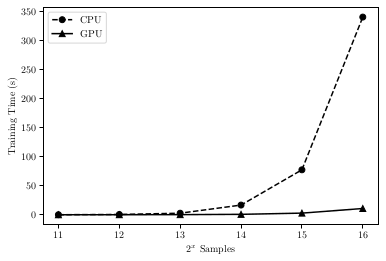

In [98]:
# Plot data
x_axis = list(range(11, 17))

plt.plot(x_axis, skSVC_info, label = 'CPU', linestyle = '--', marker = 'o', color = 'black')
plt.plot(x_axis, cuSVC_info, label = 'GPU', linestyle = '-', marker = '^', color = 'black')
plt.xlabel('$2^x$ Samples')
plt.ylabel('Training Time (s)')
plt.legend()
plt.savefig('raw_out/raw_svm.pgf')

In [11]:
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

skRFC_info = []

for item in n_samples:
    curr_run_time = []
    i = 0
    sample = scaled_df.sample(item, replace = False, random_state = 42)

    sample_X = sample.iloc[:, :-1].astype('float32')
    sample_y = sample.y.astype('float32')
    print('Running', str(item))
    while i < 5:
        start = time.time()

        clf = skRFC(max_depth = 16, n_jobs = -1)
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        curr_run_time.append(time_taken)
        
        i += 1


    skRFC_info.append(np.array(curr_run_time).mean())
    
    
# max_depth = 16

Running 2048
Running 4096
Running 8192
Running 16384
Running 32768
Running 65536


In [17]:
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

cuRFC_info = []

for item in n_samples:
    curr_run_time = []
    i = 0
    sample = scaled_df.sample(item, replace = False, random_state = 42)
    
    sample_X = sample.iloc[:, :-1].astype('float32')
    sample_y = sample.y.astype('float32')
    
    print('Running', str(item))
    while i < 5:

        start = time.time()

        clf = cuRFC()
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        curr_run_time.append(time_taken)
        
        i += 1

                
    
    cuRFC_info.append(np.array(curr_run_time).mean())
    
# max_depth = 16

Running 2048
Running 4096
Running 8192
Running 16384
Running 32768
Running 65536


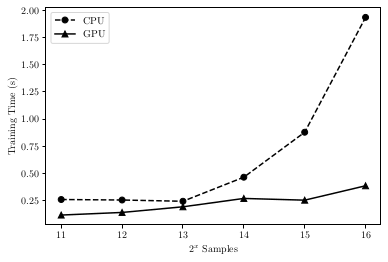

In [27]:
x_axis = list(range(11, 17))

plt.plot(x_axis, skRFC_info, label = 'CPU', linestyle = '--', marker = 'o', color = 'black')
plt.plot(x_axis, cuRFC_info, label = 'GPU', linestyle = '-', marker = '^', color = 'black')
plt.xlabel('$2^x$ Samples')
plt.ylabel('Training Time (s)')
plt.legend()
plt.savefig('raw_out/raw_rfc.pgf')
#plt.show()

In [19]:
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

skLogReg_info = []

for item in n_samples:
    curr_run_time = []
    i = 0

    sample = scaled_df.sample(item, replace = False, random_state = 42)
    
    sample_X = sample.iloc[:, :-1]
    sample_y = sample.y
    
    while i < 5:

        start = time.time()

        clf = skLogReg(max_iter = 1000)
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        
        curr_run_time.append(time_taken)
        i += 1

                
    
    skLogReg_info.append(np.array(curr_run_time).mean())
    
    
# max_iter = 1000

In [22]:
n_samples = range(11, 17)
n_samples = [2 ** item for item in n_samples]

cuLogReg_info = []

for item in n_samples:
    curr_run_time = []
    i = 0

    sample = scaled_df.sample(item, replace = False, random_state = 42)
    
    sample_X = sample.iloc[:, :-1]
    sample_y = sample.y
    
    while i < 5:

        start = time.time()

        clf = cuLogReg()
        clf.fit(sample_X, sample_y)

        time_taken = time.time() - start
        
        curr_run_time.append(time_taken)
        i += 1

                
    
    cuLogReg_info.append(np.array(curr_run_time).mean())
    
    
# max_iter = 1000

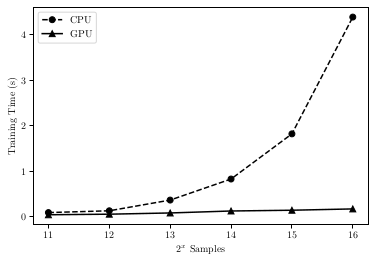

In [28]:
x_axis = list(range(11, 17))

plt.plot(x_axis, skLogReg_info, label = 'CPU', linestyle = '--', marker = 'o', color = 'black')
plt.plot(x_axis, cuLogReg_info, label = 'GPU', linestyle = '-', marker = '^', color = 'black')
plt.xlabel('$2^x$ Samples')
plt.ylabel('Training Time (s)')
plt.legend()
plt.savefig('raw_out/raw_log_reg.pgf')
#plt.show()